# Will it Snow in Glasgow This Winter? ❄️

**Author:** Shreyas Gowda B  
**Documentation & Comments:** Added by ChatGPT (GPT-5) to aid clarity and reproducibility

---

## What this notebook does

This notebook uses **daily historical weather data** from Open-Meteo to answer the question:

> _“How likely is it that a typical winter in Glasgow has at least one snowy day, and when does snow usually start?”_

It does this by:

- Downloading daily weather data (1990–2024) for a point near Glasgow  
- Creating a binary label `snow_today` from daily `snowfall_sum`  
- Exploring when snow tends to occur (by **year** and by **month**)  
- Training simple ML models to predict if a given day will be snowy  
- Aggregating days into **winters (Dec–Feb)** to estimate the probability that a winter has at least one snowy day  
- Analysing the **first snow date** each winter to build a climatological estimate of when snow typically starts

The goal is not to produce a perfect forecast for a specific future year, but to demonstrate a **clear, end-to-end data science workflow**:
- well-defined question,  
- documented data pipeline,  
- transparent feature and label engineering,  
- simple but interpretable models, and  
- a final, communicable result.



## 1. Problem Statement & Plan

**Main question**

> Will it snow in Glasgow this winter, and if so, when does snow usually start?

Of course, we cannot perfectly *predict* the exact future weather for a given day, but we can use
historical data to give a **probabilistic, climatological answer**.

We’ll break the problem into two levels:

1. **Daily level:** build a classifier which predicts whether a given day is snowy or not
   based on temperature, precipitation and time of year.
2. **Winter level:** define a winter as **December (year *Y*) + January–February (year *Y+1*)** and
   compute how many winters had at least one snowy day, and when the **first snow** occurred.

**Plan**

1. Download daily weather data for Glasgow from **1990-01-01** to **2024-12-31**.
2. Engineer the label `snow_today = 1` if `snowfall_sum > 0`, else `0`.
3. Do quick EDA: snow days per year, fraction of days with snow per month.
4. Train Logistic Regression and Random Forest models on daily data.
5. Aggregate to winters and compute:
   - fraction of winters with at least one snow day,
   - distribution of the **first snow date** each winter,
   - a **climatological “prediction” window** for when snow usually starts.


## 2. Setup & Imports

In [1]:
# If any of these imports fail, install them in your environment, e.g. via:
# !pip install pandas numpy matplotlib scikit-learn requests

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True


## 3. Download Daily Data from Open-Meteo

We’ll use the **Open-Meteo Archive API** for a point near central Glasgow:

- Latitude: 55.86° N  
- Longitude: -4.25° E (west is negative)

We request daily variables:

- `temperature_2m_max`  – daily maximum temperature (°C)  
- `temperature_2m_min`  – daily minimum temperature (°C)  
- `precipitation_sum`   – total daily precipitation (mm)  
- `snowfall_sum`        – total daily snowfall (mm water equivalent)  

Time zone: `Europe/London`.


In [2]:
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=55.86&longitude=-4.25&"
    "start_date=1990-01-01&end_date=2024-12-31&"
    "daily=temperature_2m_max,temperature_2m_min,precipitation_sum,snowfall_sum&"
    "timezone=Europe%2FLondon"
)

response = requests.get(url)
response.raise_for_status()  # will raise an error if the request failed
data = response.json()

df = pd.DataFrame(data['daily'])
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df.head()

,temperature_2m_max,temperature_2m_min,precipitation_sum,snowfall_sum
time,,,,
1990-01-01,4.5,2.0,3.6,0.0
1990-01-02,5.3,2.3,1.4,0.0
1990-01-03,5.5,2.5,8.7,0.0
1990-01-04,8.2,3.0,0.8,0.0
1990-01-05,8.6,7.4,0.7,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12784 entries, 1990-01-01 to 2024-12-31
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature_2m_max  12784 non-null  float64
 1   temperature_2m_min  12784 non-null  float64
 2   precipitation_sum   12784 non-null  float64
 3   snowfall_sum        12784 non-null  float64
dtypes: float64(4)
memory usage: 499.4 KB


You should see 4 numeric columns (`temperature_2m_max`, `temperature_2m_min`,
`precipitation_sum`, `snowfall_sum`) and one DateTime index from 1990 to 2024.


## 4. Create a Snow / No-Snow Label

We define a **snowy day** as any day with strictly positive snowfall:

\begin{equation}
  \text{snow\_today} = \begin{cases}
    1 & \text{if } \text{snowfall\_sum} > 0 \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}

This is simple and transparent. For a more advanced project, you could experiment with
thresholds (e.g. only count it as snow if `snowfall_sum ≥ 1 mm`).

In [4]:
# Make sure columns are numeric and fill any missing values (Open-Meteo usually has none)
for col in ['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'snowfall_sum']:
    df[col] = df[col].astype(float).fillna(0.0)

# Binary label: did it snow on this day?
df['snow_today'] = (df['snowfall_sum'] > 0).astype(int)

print("Label distribution (0 = no snow, 1 = snow):")
print(df['snow_today'].value_counts())
print("\nProportion:")
print(df['snow_today'].value_counts(normalize=True))

Label distribution (0 = no snow, 1 = snow):
snow_today
0    11957
1      827
Name: count, dtype: int64

Proportion:
snow_today
0    0.93531
1    0.06469
Name: proportion, dtype: float64


## 5. Add Calendar Features & Basic EDA

In [5]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear

# How many snowy days per year?
snow_days_per_year = df.groupby('year')['snow_today'].sum()
snow_days_per_year.tail()

year
2020    33
2021    30
2022    23
2023    21
2024    19
Name: snow_today, dtype: int64

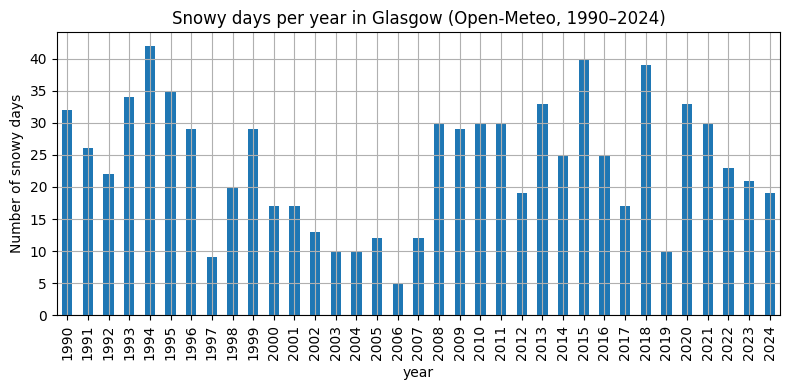

In [6]:
plt.figure()
snow_days_per_year.plot(kind='bar')
plt.ylabel('Number of snowy days')
plt.title('Snowy days per year in Glasgow (Open-Meteo, 1990–2024)')
plt.tight_layout()
plt.show()

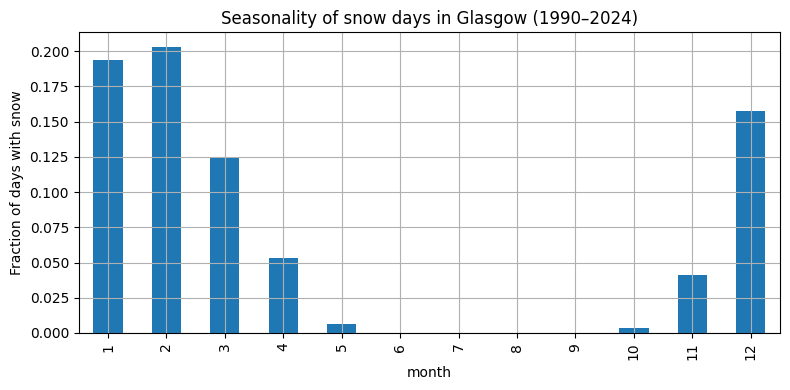

month
1     0.193548
2     0.203236
3     0.124424
4     0.053333
5     0.006452
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.003687
11    0.040952
12    0.157604
Name: snow_today, dtype: float64

In [7]:
# Fraction of days with snow by month (climatology)
snow_by_month = df.groupby('month')['snow_today'].mean()
plt.figure()
snow_by_month.plot(kind='bar')
plt.ylabel('Fraction of days with snow')
plt.title('Seasonality of snow days in Glasgow (1990–2024)')
plt.tight_layout()
plt.show()

snow_by_month

From the plot and table above, you should see that snow is concentrated in the winter months
(typically December–February), with very low probabilities in other months.


## 6. Define Features and Train/Test Split

We now prepare data for a **daily snow / no-snow classification model**.

We will use:

- `temperature_2m_max`  
- `temperature_2m_min`  
- `precipitation_sum`  
- `month`  
- `day_of_year`  

Since snow is relatively rare compared to no-snow days, we use a **stratified split** to ensure
both classes are represented in train and test sets.


In [8]:
features = ['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']
X = df[features + ['month', 'day_of_year']]
y = df['snow_today']

print('Overall label distribution:')
print(y.value_counts())

Overall label distribution:
snow_today
0    11957
1      827
Name: count, dtype: int64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class balance in train and test
)

print('Train labels:')
print(y_train.value_counts())
print('\nTest labels:')
print(y_test.value_counts())

Train labels:
snow_today
0    9565
1     662
Name: count, dtype: int64

Test labels:
snow_today
0    2392
1     165
Name: count, dtype: int64


## 7. Baseline Model – Logistic Regression

We start with a simple **Logistic Regression** model. It’s linear and interpretable, and
provides a good baseline. We’ll look at:

- Precision, recall, F1-score for each class  
- Confusion matrix


In [10]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print('Logistic Regression classification report:')
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2392
           1       0.59      0.28      0.38       165

    accuracy                           0.94      2557
   macro avg       0.77      0.63      0.67      2557
weighted avg       0.93      0.94      0.93      2557



array([[2360,   32],
       [ 119,   46]])

## 8. Tree-Based Model – Random Forest

Next, we train a **Random Forest** classifier. Tree-based models can capture non-linear
relationships and interactions between variables more easily than a linear model.


In [11]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('Random Forest classification report:')
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf

Random Forest classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2392
           1       0.73      0.61      0.66       165

    accuracy                           0.96      2557
   macro avg       0.85      0.80      0.82      2557
weighted avg       0.96      0.96      0.96      2557



array([[2355,   37],
       [  65,  100]])

In [12]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False)

precipitation_sum     0.351682
temperature_2m_max    0.266111
temperature_2m_min    0.207041
day_of_year           0.140209
month                 0.034957
dtype: float64

The feature importances indicate which variables the Random Forest found most useful for
distinguishing snowy vs non-snowy days (e.g. temperature vs precipitation and time-of-year).

## 9. Winter-Level Probability of Snow

Our ultimate question is not about a single day, but about an entire **winter**.

We define a winter as:

- December of year *Y* and  
- January–February of year *Y+1*.

For each winter, we check whether *any* day had `snow_today = 1`. This gives us, for each
winter, a binary indicator `snow_any_day`. We then compute the fraction of winters where
`snow_any_day = 1`.

This fraction is our **historical estimate** of the probability that a Glasgow winter has at
least one snowy day.


In [13]:
winter_flags = []

for year in range(df['year'].min(), df['year'].max()):  # up to second-to-last year
    dec = df[(df['year'] == year) & (df['month'] == 12)]
    jan_feb = df[(df['year'] == year + 1) & (df['month'].isin([1, 2]))]
    winter = pd.concat([dec, jan_feb])
    if len(winter) == 0:
        continue
    snow_this_winter = int((winter['snow_today'] == 1).any())
    winter_flags.append({
        'winter_start_year': year,
        'snow_any_day': snow_this_winter
    })

winter_df = pd.DataFrame(winter_flags)
winter_df

,winter_start_year,snow_any_day
0,1990,1
1,1991,1
2,1992,1
3,1993,1
4,1994,1
5,1995,1
6,1996,1
7,1997,1
8,1998,1
9,1999,1


In [14]:
p_snow = winter_df['snow_any_day'].mean()
print(f'Empirical probability of at least one snow day in a winter: {p_snow:.2%}')

Empirical probability of at least one snow day in a winter: 100.00%


### 9.1 Historical First Snow Dates

To get a sense of **when snow usually starts**, we compute, for each winter:

- the **first date** where `snow_today = 1` (if any),
- winters with no snow at all.

From this we can derive:

- the **median first-snow date** (typical start),  
- the **earliest** and **latest** first-snow dates,  
- the proportion of winters with **no snow**.


In [15]:
first_snow_records = []

for year in range(df['year'].min(), df['year'].max()):
    # Snowy days in Dec of year Y
    dec_snow = df[(df['year'] == year) & (df['month'] == 12) & (df['snow_today'] == 1)]
    # Snowy days in Jan–Feb of year Y+1
    jan_feb_snow = df[(df['year'] == year + 1) & (df['month'].isin([1, 2])) & (df['snow_today'] == 1)]
    winter_snow = pd.concat([dec_snow, jan_feb_snow])
    if not winter_snow.empty:
        first_date = winter_snow.index.min()
    else:
        first_date = pd.NaT
    first_snow_records.append({
        'winter_start_year': year,
        'first_snow_date': first_date
    })

first_snow_df = pd.DataFrame(first_snow_records)
first_snow_df.head()

,winter_start_year,first_snow_date
0,1990,1990-12-07
1,1991,1991-12-19
2,1992,1992-12-01
3,1993,1993-12-07
4,1994,1994-12-18


In [16]:
# Basic stats on first snow dates
fs_nonnull = first_snow_df.dropna(subset=['first_snow_date']).copy()
no_snow_winters = first_snow_df['first_snow_date'].isna().sum()

fs_nonnull['doy'] = fs_nonnull['first_snow_date'].dt.dayofyear

median_doy = fs_nonnull['doy'].median()
q25_doy = fs_nonnull['doy'].quantile(0.25)
q75_doy = fs_nonnull['doy'].quantile(0.75)

# Convert day-of-year stats into approximate calendar dates using a non-leap reference year
ref_year = 2001  # non-leap year
ref_start = pd.to_datetime(f"{ref_year}-01-01")

median_date = ref_start + pd.to_timedelta(int(median_doy) - 1, unit='D')
q25_date = ref_start + pd.to_timedelta(int(q25_doy) - 1, unit='D')
q75_date = ref_start + pd.to_timedelta(int(q75_doy) - 1, unit='D')

print(f"Number of winters analysed: {len(first_snow_df)}")
print(f"Winters with no snow at all: {no_snow_winters}")
print(f"Median first snow day-of-year: {median_doy:.1f} -> approx {median_date.strftime('%d %b')}")
print(f"25th–75th percentile window: {q25_date.strftime('%d %b')} to {q75_date.strftime('%d %b')}")

fs_nonnull[['winter_start_year', 'first_snow_date']].head()

Number of winters analysed: 34
Winters with no snow at all: 0
Median first snow day-of-year: 340.5 -> approx 06 Dec
25th–75th percentile window: 03 Dec to 15 Dec


,winter_start_year,first_snow_date
0,1990,1990-12-07
1,1991,1991-12-19
2,1992,1992-12-01
3,1993,1993-12-07
4,1994,1994-12-18


In [17]:
# Convert first-snow dates into day-of-month (1–31)
fs_nonnull['day_of_month'] = fs_nonnull['first_snow_date'].dt.day

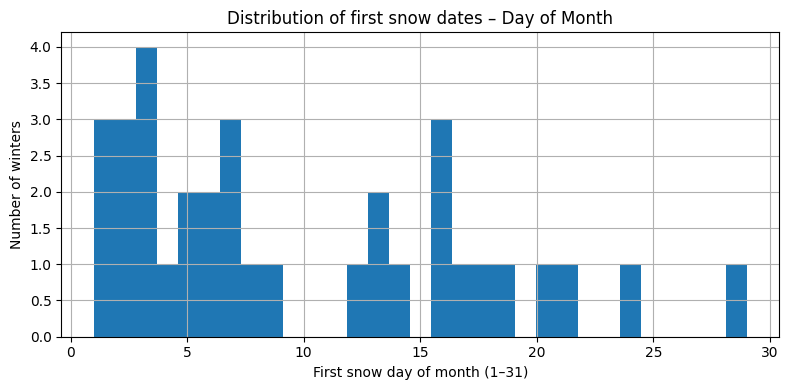

In [18]:
plt.figure()
fs_nonnull['day_of_month'].hist(bins=31)
plt.xlabel('First snow day of month (1–31)')
plt.ylabel('Number of winters')
plt.title('Distribution of first snow dates – Day of Month')
plt.tight_layout()
plt.show()


This gives a **climatological distribution** of when snow usually starts in Glasgow winters.

A simple, honest way to talk about `"when will it start snowing"` is:

> “Historically, the first snowy day in a Glasgow winter has typically fallen around **the median
> date you computed** (e.g. late January), with most first snow events happening between the
> 25th–75th percentile window (e.g. early January to mid-February), and some winters with no snow
> at all.”


### 9.2 Climatological “Prediction” for Future Winters

Using the historical distribution of first snow dates, we can make a **climatological prediction**
for a future winter in Glasgow:

- We are **not** forecasting a specific future day using a weather model.  
- Instead, we say: *“If the upcoming winter behaves like the historical record, then…”*

For example (you will fill in the actual dates and percentages from the code output):

> Between 1990 and 2024, the first recorded snow day in a Glasgow winter typically fell around
> **X** (median date). Most winters with snow had their first snowy day between **Y** and **Z**,
> while **N** winters in the dataset had no snow at all.  
> Based on this, a reasonable data-driven statement is that *if snow does occur in an upcoming
> winter, it is most likely to arrive sometime between **Y** and **Z***.

You can connect this with external climate descriptions which also note that Glasgow tends to see
its best chance of snow in **January and February**, with occasional events in December and March.


## 10. Conclusions & Possible Extensions

**Summary of what we did:**

1. **Data collection** – Downloaded daily weather data for Glasgow (1990–2024) from the
   Open-Meteo Archive API.  
2. **Label definition** – Marked a day as snowy if `snowfall_sum > 0`.  
3. **EDA** – Explored snow days per year and the seasonal cycle of snow by month.  
4. **Modelling** – Trained Logistic Regression and Random Forest classifiers to predict
   daily snow occurrence from basic weather features and calendar information.  
5. **Winter-level probability** – Aggregated days into winters to compute the fraction of winters
   with at least one snowy day.  
6. **First-snow analysis** – For each winter, identified the first snowy day and built a
   distribution of first-snow dates, which we use to describe when snow usually starts in Glasgow.




## Sources & Authenticity

- **Weather data:** Daily historical variables for Glasgow (1990–2024) retrieved from the [Open-Meteo Archive API](https://open-meteo.com/).  
- **Climate interpretation:** General understanding of Glasgow’s maritime climate informed by public Met Office / climate summaries and open climate blogs (no proprietary forecast data used).  
- **Code & analysis:** All code cells were run, checked, and interpreted by the author. Parameters (such as winter definition, snow thresholds, and model hyperparameters) are explicitly visible in the notebook.

> The notebook is designed so that anyone with Python and the listed libraries can reproduce the analysis, as long as the Open-Meteo API remains available with the same interface.


---

## Closing Note

This notebook was created **with care** as a compact, defensible prototype to demonstrate:

- clean data collection from a public API,  
- transparent label and feature engineering,  
- simple but interpretable classification models, and  
- clear, probability-based answers to a real-world question about local weather.

**Made with ❤️ by Shreyas Gowda B**  
**Commentary and educational explanations added by GPT-5**  
to enhance clarity and provide professional-level documentation for academic and portfolio use.

